In [3]:
import torch
import torch.nn as nn
import torchvision
import torchvision.datasets as datasets
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
import torch.nn.functional as F
import torch.optim as optim
from tqdm import tqdm
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [4]:
# Hyperparams
BATCH_SIZE = 16
LR = 0.001
NUM_WORKERS = 8
EPOCHS=100
MOMENTUM = 0.9
WEIGHT_DECAY = 1e-4
DEVICE = torch.device('cuda:3')

In [5]:
normMean = [0.485, 0.456, 0.406]
normStd = [0.229, 0.224, 0.225]
normTransform = transforms.Normalize(normMean, normStd)

trainTransform = transforms.Compose([
        transforms.Resize(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        normTransform
    ])
testTransform = transforms.Compose([
        transforms.Resize(224),
        transforms.ToTensor(),
        normTransform
    ])

In [6]:
train_dataset = datasets.CIFAR10(root='data', train=True, download=True, transform=trainTransform)
test_dataset = datasets.CIFAR10(root='data', train=False, download=True, transform=testTransform)

train_loader = DataLoader(dataset=train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=NUM_WORKERS, pin_memory=True)
test_loader = DataLoader(dataset=test_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=NUM_WORKERS, pin_memory=True)

Files already downloaded and verified
Files already downloaded and verified


In [7]:
model = torchvision.models.resnet50(pretrained=True)
    # for p in model.parameters():
    #     p.requires_grad = False
num_fltrs = model.fc.in_features
model.fc = nn.Linear(num_fltrs, 10)

model = model.to(DEVICE)

In [6]:
print(model)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

In [7]:
criterion = nn.CrossEntropyLoss()

optimizer = torch.optim.SGD(model.parameters(), LR,
                            momentum=MOMENTUM,
                            weight_decay=WEIGHT_DECAY, nesterov=True)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max = EPOCHS)

In [8]:
def trainEpoch(device, model, loader, optimizer, criterion):
    loop = tqdm(loader)
    model.train()

    losses = []
    correct = 0
    total = 0
    for batch_id, (images, labels) in enumerate(loop):
        images, labels = images.to(device), labels.to(device)
        model = model.to(device)
       
        outputs = model(images)

        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted==labels).sum().item()

        loss = criterion(outputs, labels)
        losses.append(loss.item())


        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        loop.set_postfix(train_loss=loss.item(), train_accuracy=(100*correct/total))

    return np.mean(losses), 100*correct/total


def testEpoch(device, model, loader, criterion):
    
    model.eval()
    with torch.no_grad():
        losses = []
        correct = 0
        total = 0
        loop = tqdm(loader)
        for batch_id, (images, labels) in enumerate(loop):
            images, labels = images.to(device), labels.to(device)
            model = model.to(device)
        
            outputs = model(images)

            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted==labels).sum().item()

            loss = criterion(outputs, labels)
            losses.append(loss.item())

            loop.set_postfix(test_loss=loss.item(), test_accuracy=(100*correct/total))

        return np.mean(losses), 100*correct/total

In [9]:
last_best = 0
train_losses = []
train_acc = []
test_losses = []
test_acc = []
for epoch in range (EPOCHS):
    
    train_loss, train_accuracy = trainEpoch(DEVICE, model, train_loader, optimizer, criterion)
    test_loss, test_accuracy = testEpoch(DEVICE, model, test_loader, criterion)

    train_losses.append(train_loss)
    train_acc.append(train_accuracy)
    test_losses.append(test_loss)
    test_acc.append(test_accuracy)

    scheduler.step()

    if last_best <= test_accuracy:
        torch.save(model.state_dict(), 'resnet_50_pretrained_baseline.pt')
        print("Saving new Best Model!")
        last_best = test_accuracy

    print(f"Epoch-{epoch+1} Train Loss: {train_losses[-1]:.4f} Train Accuracy: {train_acc[-1]:.4f}")
    print(f"Epoch-{epoch+1} Test Loss: {test_losses[-1]:.4f} Test Accuracy: {test_acc[-1]:.4f}")

dict = {'train_loss': train_losses, 'train_accuracy': train_acc, 'test_loss': test_losses, 'test_accuracy': test_acc}
df = pd.DataFrame(dict)
df.to_csv('loss_and_acc_resnet50_baseline.csv')

100%|██████████| 625/625 [00:20<00:00, 29.92it/s, test_accuracy=94.5, test_loss=0.405]  


Saving new Best Model!
Epoch-1 Train Loss: 0.3340 Train Accuracy: 89.0040
Epoch-1 Test Loss: 0.1604 Test Accuracy: 94.5500


100%|██████████| 625/625 [00:20<00:00, 29.80it/s, test_accuracy=95.5, test_loss=0.00394]


Saving new Best Model!
Epoch-2 Train Loss: 0.1513 Train Accuracy: 94.9600
Epoch-2 Test Loss: 0.1335 Test Accuracy: 95.4900


100%|██████████| 625/625 [00:20<00:00, 30.05it/s, test_accuracy=96, test_loss=0.0239]    


Saving new Best Model!
Epoch-3 Train Loss: 0.0980 Train Accuracy: 96.7080
Epoch-3 Test Loss: 0.1273 Test Accuracy: 95.9700


100%|██████████| 625/625 [00:21<00:00, 29.50it/s, test_accuracy=95.7, test_loss=0.0294]  


Epoch-4 Train Loss: 0.0735 Train Accuracy: 97.5220
Epoch-4 Test Loss: 0.1313 Test Accuracy: 95.7400


100%|██████████| 625/625 [00:20<00:00, 29.87it/s, test_accuracy=96.2, test_loss=0.0569]  


Saving new Best Model!
Epoch-5 Train Loss: 0.0547 Train Accuracy: 98.1140
Epoch-5 Test Loss: 0.1192 Test Accuracy: 96.2200


100%|██████████| 625/625 [00:21<00:00, 29.70it/s, test_accuracy=96, test_loss=0.352]     


Epoch-6 Train Loss: 0.0413 Train Accuracy: 98.6440
Epoch-6 Test Loss: 0.1378 Test Accuracy: 95.9900


100%|██████████| 625/625 [00:21<00:00, 29.70it/s, test_accuracy=96.6, test_loss=0.0107]  


Saving new Best Model!
Epoch-7 Train Loss: 0.0343 Train Accuracy: 98.9180
Epoch-7 Test Loss: 0.1156 Test Accuracy: 96.6300


100%|██████████| 625/625 [00:19<00:00, 32.86it/s, test_accuracy=96.6, test_loss=0.107]   


Epoch-8 Train Loss: 0.0272 Train Accuracy: 99.0960
Epoch-8 Test Loss: 0.1238 Test Accuracy: 96.5800


100%|██████████| 625/625 [00:20<00:00, 29.79it/s, test_accuracy=96.5, test_loss=0.5]     


Epoch-9 Train Loss: 0.0225 Train Accuracy: 99.2660
Epoch-9 Test Loss: 0.1213 Test Accuracy: 96.4700


100%|██████████| 625/625 [00:21<00:00, 29.75it/s, test_accuracy=96.2, test_loss=0.0201]  


Epoch-10 Train Loss: 0.0215 Train Accuracy: 99.3140
Epoch-10 Test Loss: 0.1365 Test Accuracy: 96.2300


100%|██████████| 625/625 [00:21<00:00, 29.62it/s, test_accuracy=96.6, test_loss=0.0025]  


Saving new Best Model!
Epoch-11 Train Loss: 0.0172 Train Accuracy: 99.4700
Epoch-11 Test Loss: 0.1190 Test Accuracy: 96.6400


100%|██████████| 625/625 [00:20<00:00, 29.81it/s, test_accuracy=96.6, test_loss=0.0131]  


Epoch-12 Train Loss: 0.0122 Train Accuracy: 99.6000
Epoch-12 Test Loss: 0.1273 Test Accuracy: 96.6100


100%|██████████| 625/625 [00:21<00:00, 29.66it/s, test_accuracy=96.6, test_loss=0.366]   


Epoch-13 Train Loss: 0.0105 Train Accuracy: 99.6640
Epoch-13 Test Loss: 0.1307 Test Accuracy: 96.5800


100%|██████████| 625/625 [00:21<00:00, 29.69it/s, test_accuracy=96.9, test_loss=0.00365] 


Saving new Best Model!
Epoch-14 Train Loss: 0.0119 Train Accuracy: 99.6420
Epoch-14 Test Loss: 0.1214 Test Accuracy: 96.8900


100%|██████████| 625/625 [00:19<00:00, 32.79it/s, test_accuracy=96.9, test_loss=0.383]   


Saving new Best Model!
Epoch-15 Train Loss: 0.0104 Train Accuracy: 99.6840
Epoch-15 Test Loss: 0.1147 Test Accuracy: 96.9200


100%|██████████| 625/625 [00:20<00:00, 29.84it/s, test_accuracy=97, test_loss=0.0126]    


Saving new Best Model!
Epoch-16 Train Loss: 0.0057 Train Accuracy: 99.8460
Epoch-16 Test Loss: 0.1125 Test Accuracy: 96.9700


100%|██████████| 625/625 [00:21<00:00, 29.40it/s, test_accuracy=96.9, test_loss=0.0253]  


Epoch-17 Train Loss: 0.0077 Train Accuracy: 99.7680
Epoch-17 Test Loss: 0.1200 Test Accuracy: 96.8700


100%|██████████| 625/625 [00:21<00:00, 29.55it/s, test_accuracy=96.8, test_loss=0.0347]  


Epoch-18 Train Loss: 0.0051 Train Accuracy: 99.8580
Epoch-18 Test Loss: 0.1238 Test Accuracy: 96.8300


100%|██████████| 625/625 [00:20<00:00, 29.93it/s, test_accuracy=96.9, test_loss=0.139]   


Epoch-19 Train Loss: 0.0061 Train Accuracy: 99.8240
Epoch-19 Test Loss: 0.1144 Test Accuracy: 96.8700


100%|██████████| 625/625 [00:21<00:00, 29.68it/s, test_accuracy=97, test_loss=0.000626]  


Saving new Best Model!
Epoch-20 Train Loss: 0.0046 Train Accuracy: 99.8640
Epoch-20 Test Loss: 0.1129 Test Accuracy: 97.0300


100%|██████████| 625/625 [00:21<00:00, 29.58it/s, test_accuracy=96.8, test_loss=0.79]    


Epoch-21 Train Loss: 0.0040 Train Accuracy: 99.8920
Epoch-21 Test Loss: 0.1255 Test Accuracy: 96.7500


100%|██████████| 625/625 [00:19<00:00, 31.73it/s, test_accuracy=97.5, test_loss=0.00026] 


Saving new Best Model!
Epoch-22 Train Loss: 0.0032 Train Accuracy: 99.9280
Epoch-22 Test Loss: 0.1068 Test Accuracy: 97.5100


100%|██████████| 625/625 [00:21<00:00, 29.60it/s, test_accuracy=97.2, test_loss=0.00271] 


Epoch-23 Train Loss: 0.0034 Train Accuracy: 99.8980
Epoch-23 Test Loss: 0.1143 Test Accuracy: 97.2100


100%|██████████| 625/625 [00:20<00:00, 29.96it/s, test_accuracy=97, test_loss=0.00151]   


Epoch-24 Train Loss: 0.0047 Train Accuracy: 99.8660
Epoch-24 Test Loss: 0.1141 Test Accuracy: 96.9800


100%|██████████| 625/625 [00:21<00:00, 29.74it/s, test_accuracy=97, test_loss=0.391]     


Epoch-25 Train Loss: 0.0033 Train Accuracy: 99.9060
Epoch-25 Test Loss: 0.1122 Test Accuracy: 97.0300


100%|██████████| 625/625 [00:21<00:00, 29.67it/s, test_accuracy=97, test_loss=0.0398]    


Epoch-26 Train Loss: 0.0030 Train Accuracy: 99.9300
Epoch-26 Test Loss: 0.1134 Test Accuracy: 97.0300


100%|██████████| 625/625 [00:20<00:00, 29.85it/s, test_accuracy=97.1, test_loss=0.16]    


Epoch-27 Train Loss: 0.0028 Train Accuracy: 99.9320
Epoch-27 Test Loss: 0.1069 Test Accuracy: 97.1100


100%|██████████| 625/625 [00:12<00:00, 49.32it/s, test_accuracy=97.2, test_loss=0.0103]  


Epoch-28 Train Loss: 0.0017 Train Accuracy: 99.9620
Epoch-28 Test Loss: 0.1086 Test Accuracy: 97.2100


100%|██████████| 625/625 [00:13<00:00, 47.61it/s, test_accuracy=97.3, test_loss=0.000153]


Epoch-29 Train Loss: 0.0014 Train Accuracy: 99.9780
Epoch-29 Test Loss: 0.1080 Test Accuracy: 97.2600


100%|██████████| 625/625 [00:12<00:00, 48.77it/s, test_accuracy=97.2, test_loss=8.92e-5] 


Epoch-30 Train Loss: 0.0018 Train Accuracy: 99.9520
Epoch-30 Test Loss: 0.1065 Test Accuracy: 97.2000


100%|██████████| 625/625 [00:12<00:00, 48.69it/s, test_accuracy=97.4, test_loss=0.539]   


Epoch-31 Train Loss: 0.0015 Train Accuracy: 99.9740
Epoch-31 Test Loss: 0.0965 Test Accuracy: 97.3900


100%|██████████| 625/625 [00:12<00:00, 49.42it/s, test_accuracy=97.4, test_loss=0.417]   


Epoch-32 Train Loss: 0.0009 Train Accuracy: 99.9840
Epoch-32 Test Loss: 0.1041 Test Accuracy: 97.3600


100%|██████████| 625/625 [00:12<00:00, 49.97it/s, test_accuracy=97.3, test_loss=1.39e-5] 


Epoch-33 Train Loss: 0.0011 Train Accuracy: 99.9720
Epoch-33 Test Loss: 0.1056 Test Accuracy: 97.2700


100%|██████████| 625/625 [00:12<00:00, 48.97it/s, test_accuracy=97.5, test_loss=3.62e-5] 


Epoch-34 Train Loss: 0.0008 Train Accuracy: 99.9880
Epoch-34 Test Loss: 0.1023 Test Accuracy: 97.4600


100%|██████████| 625/625 [00:12<00:00, 49.15it/s, test_accuracy=97.4, test_loss=0.00354] 


Epoch-35 Train Loss: 0.0009 Train Accuracy: 99.9760
Epoch-35 Test Loss: 0.1032 Test Accuracy: 97.3600


100%|██████████| 625/625 [00:12<00:00, 49.23it/s, test_accuracy=97.3, test_loss=0.039]   


Epoch-36 Train Loss: 0.0009 Train Accuracy: 99.9900
Epoch-36 Test Loss: 0.1046 Test Accuracy: 97.3400


100%|██████████| 625/625 [00:12<00:00, 48.98it/s, test_accuracy=97.5, test_loss=0.0621]  


Epoch-37 Train Loss: 0.0008 Train Accuracy: 99.9880
Epoch-37 Test Loss: 0.0960 Test Accuracy: 97.4800


100%|██████████| 625/625 [00:12<00:00, 48.20it/s, test_accuracy=97.5, test_loss=0.00018] 


Epoch-38 Train Loss: 0.0007 Train Accuracy: 99.9900
Epoch-38 Test Loss: 0.0985 Test Accuracy: 97.5000


100%|██████████| 625/625 [00:12<00:00, 48.52it/s, test_accuracy=97.6, test_loss=0.000471]


Saving new Best Model!
Epoch-39 Train Loss: 0.0006 Train Accuracy: 99.9900
Epoch-39 Test Loss: 0.0968 Test Accuracy: 97.5700


100%|██████████| 625/625 [00:12<00:00, 49.11it/s, test_accuracy=97.4, test_loss=0.00179] 


Epoch-40 Train Loss: 0.0005 Train Accuracy: 99.9940
Epoch-40 Test Loss: 0.1001 Test Accuracy: 97.4100


100%|██████████| 625/625 [00:12<00:00, 48.90it/s, test_accuracy=97.5, test_loss=0.144]   


Epoch-41 Train Loss: 0.0005 Train Accuracy: 99.9940
Epoch-41 Test Loss: 0.0978 Test Accuracy: 97.5500


100%|██████████| 625/625 [00:13<00:00, 47.70it/s, test_accuracy=97.5, test_loss=0.131]   


Epoch-42 Train Loss: 0.0005 Train Accuracy: 99.9920
Epoch-42 Test Loss: 0.0973 Test Accuracy: 97.5500


100%|██████████| 625/625 [00:12<00:00, 49.31it/s, test_accuracy=97.5, test_loss=0.33]    


Epoch-43 Train Loss: 0.0004 Train Accuracy: 99.9980
Epoch-43 Test Loss: 0.0981 Test Accuracy: 97.4700


100%|██████████| 625/625 [00:12<00:00, 49.11it/s, test_accuracy=97.6, test_loss=0.00236] 


Saving new Best Model!
Epoch-44 Train Loss: 0.0003 Train Accuracy: 99.9980
Epoch-44 Test Loss: 0.0949 Test Accuracy: 97.6200


100%|██████████| 625/625 [00:12<00:00, 49.19it/s, test_accuracy=97.4, test_loss=0.571]   


Epoch-45 Train Loss: 0.0005 Train Accuracy: 99.9920
Epoch-45 Test Loss: 0.0983 Test Accuracy: 97.4400


100%|██████████| 625/625 [00:12<00:00, 49.40it/s, test_accuracy=97.4, test_loss=0.725]   


Epoch-46 Train Loss: 0.0006 Train Accuracy: 99.9880
Epoch-46 Test Loss: 0.1055 Test Accuracy: 97.3700


100%|██████████| 625/625 [00:12<00:00, 49.09it/s, test_accuracy=97.6, test_loss=0.00297] 


Epoch-47 Train Loss: 0.0003 Train Accuracy: 100.0000
Epoch-47 Test Loss: 0.0962 Test Accuracy: 97.6000


100%|██████████| 625/625 [00:12<00:00, 49.16it/s, test_accuracy=97.6, test_loss=0.000354]


Epoch-48 Train Loss: 0.0004 Train Accuracy: 99.9900
Epoch-48 Test Loss: 0.0961 Test Accuracy: 97.5700


100%|██████████| 625/625 [00:12<00:00, 49.15it/s, test_accuracy=97.7, test_loss=7.63e-5] 


Saving new Best Model!
Epoch-49 Train Loss: 0.0003 Train Accuracy: 99.9980
Epoch-49 Test Loss: 0.0936 Test Accuracy: 97.6600


100%|██████████| 625/625 [00:12<00:00, 48.50it/s, test_accuracy=97.6, test_loss=0.00865] 


Epoch-50 Train Loss: 0.0004 Train Accuracy: 99.9960
Epoch-50 Test Loss: 0.0953 Test Accuracy: 97.5600


100%|██████████| 625/625 [00:12<00:00, 49.39it/s, test_accuracy=97.6, test_loss=0.000619]


Epoch-51 Train Loss: 0.0003 Train Accuracy: 99.9940
Epoch-51 Test Loss: 0.0945 Test Accuracy: 97.5800


100%|██████████| 625/625 [00:12<00:00, 48.79it/s, test_accuracy=97.5, test_loss=0.369]   


Epoch-52 Train Loss: 0.0003 Train Accuracy: 100.0000
Epoch-52 Test Loss: 0.0975 Test Accuracy: 97.5100


100%|██████████| 625/625 [00:12<00:00, 49.03it/s, test_accuracy=97.4, test_loss=3.56e-5] 


Epoch-53 Train Loss: 0.0003 Train Accuracy: 100.0000
Epoch-53 Test Loss: 0.0993 Test Accuracy: 97.4200


100%|██████████| 625/625 [00:12<00:00, 49.05it/s, test_accuracy=97.5, test_loss=0.00434] 


Epoch-54 Train Loss: 0.0003 Train Accuracy: 99.9960
Epoch-54 Test Loss: 0.0981 Test Accuracy: 97.5000


100%|██████████| 625/625 [00:12<00:00, 48.20it/s, test_accuracy=97.6, test_loss=0.189]   


Epoch-55 Train Loss: 0.0003 Train Accuracy: 99.9980
Epoch-55 Test Loss: 0.0945 Test Accuracy: 97.6000


100%|██████████| 625/625 [00:12<00:00, 48.73it/s, test_accuracy=97.7, test_loss=0.000505]


Saving new Best Model!
Epoch-56 Train Loss: 0.0003 Train Accuracy: 99.9960
Epoch-56 Test Loss: 0.0939 Test Accuracy: 97.6600


100%|██████████| 625/625 [00:12<00:00, 48.97it/s, test_accuracy=97.5, test_loss=0.00252] 


Epoch-57 Train Loss: 0.0003 Train Accuracy: 99.9980
Epoch-57 Test Loss: 0.0964 Test Accuracy: 97.5500


100%|██████████| 625/625 [00:12<00:00, 49.56it/s, test_accuracy=97.7, test_loss=0.0159]  


Saving new Best Model!
Epoch-58 Train Loss: 0.0003 Train Accuracy: 99.9980
Epoch-58 Test Loss: 0.0938 Test Accuracy: 97.6600


100%|██████████| 625/625 [00:12<00:00, 49.04it/s, test_accuracy=97.5, test_loss=0.00188] 


Epoch-59 Train Loss: 0.0002 Train Accuracy: 99.9980
Epoch-59 Test Loss: 0.0977 Test Accuracy: 97.5300


100%|██████████| 625/625 [00:12<00:00, 49.36it/s, test_accuracy=97.6, test_loss=3.01e-5] 


Epoch-60 Train Loss: 0.0004 Train Accuracy: 99.9920
Epoch-60 Test Loss: 0.0930 Test Accuracy: 97.6300


100%|██████████| 625/625 [00:12<00:00, 49.00it/s, test_accuracy=97.6, test_loss=0.101]   


Epoch-61 Train Loss: 0.0002 Train Accuracy: 100.0000
Epoch-61 Test Loss: 0.0925 Test Accuracy: 97.6300


100%|██████████| 625/625 [00:12<00:00, 48.90it/s, test_accuracy=97.5, test_loss=0.00154] 


Epoch-62 Train Loss: 0.0002 Train Accuracy: 99.9980
Epoch-62 Test Loss: 0.0985 Test Accuracy: 97.5500


100%|██████████| 625/625 [00:12<00:00, 48.45it/s, test_accuracy=97.6, test_loss=0.485]   


Epoch-63 Train Loss: 0.0002 Train Accuracy: 100.0000
Epoch-63 Test Loss: 0.0957 Test Accuracy: 97.5800


100%|██████████| 625/625 [00:12<00:00, 48.69it/s, test_accuracy=97.7, test_loss=0.0114]  


Saving new Best Model!
Epoch-64 Train Loss: 0.0002 Train Accuracy: 100.0000
Epoch-64 Test Loss: 0.0937 Test Accuracy: 97.6700


100%|██████████| 625/625 [00:12<00:00, 49.19it/s, test_accuracy=97.6, test_loss=6.66e-5] 


Epoch-65 Train Loss: 0.0002 Train Accuracy: 100.0000
Epoch-65 Test Loss: 0.0956 Test Accuracy: 97.6400


100%|██████████| 625/625 [00:12<00:00, 49.36it/s, test_accuracy=97.6, test_loss=0.367]   


Epoch-66 Train Loss: 0.0003 Train Accuracy: 99.9920
Epoch-66 Test Loss: 0.0963 Test Accuracy: 97.5800


100%|██████████| 625/625 [00:12<00:00, 49.29it/s, test_accuracy=97.6, test_loss=0.00105] 


Epoch-67 Train Loss: 0.0003 Train Accuracy: 99.9960
Epoch-67 Test Loss: 0.0931 Test Accuracy: 97.5800


100%|██████████| 625/625 [00:12<00:00, 48.83it/s, test_accuracy=97.6, test_loss=0.0147]  


Epoch-68 Train Loss: 0.0002 Train Accuracy: 99.9980
Epoch-68 Test Loss: 0.0945 Test Accuracy: 97.5800


100%|██████████| 625/625 [00:12<00:00, 48.98it/s, test_accuracy=97.5, test_loss=0.000801]


Epoch-69 Train Loss: 0.0003 Train Accuracy: 99.9980
Epoch-69 Test Loss: 0.0937 Test Accuracy: 97.5400


100%|██████████| 625/625 [00:12<00:00, 48.93it/s, test_accuracy=97.6, test_loss=6.01e-6] 


Epoch-70 Train Loss: 0.0002 Train Accuracy: 99.9980
Epoch-70 Test Loss: 0.0930 Test Accuracy: 97.6300


100%|██████████| 625/625 [00:12<00:00, 49.16it/s, test_accuracy=97.6, test_loss=0.0558]  


Epoch-71 Train Loss: 0.0002 Train Accuracy: 100.0000
Epoch-71 Test Loss: 0.0914 Test Accuracy: 97.6200


100%|██████████| 625/625 [00:12<00:00, 49.70it/s, test_accuracy=97.5, test_loss=0.188]   


Epoch-72 Train Loss: 0.0002 Train Accuracy: 100.0000
Epoch-72 Test Loss: 0.0951 Test Accuracy: 97.5000


100%|██████████| 625/625 [00:12<00:00, 49.91it/s, test_accuracy=97.7, test_loss=0.0071]  


Saving new Best Model!
Epoch-73 Train Loss: 0.0002 Train Accuracy: 100.0000
Epoch-73 Test Loss: 0.0932 Test Accuracy: 97.6800


100%|██████████| 625/625 [00:12<00:00, 50.43it/s, test_accuracy=97.7, test_loss=3.9e-5]  


Saving new Best Model!
Epoch-74 Train Loss: 0.0002 Train Accuracy: 99.9960
Epoch-74 Test Loss: 0.0908 Test Accuracy: 97.7100


100%|██████████| 625/625 [00:12<00:00, 49.88it/s, test_accuracy=97.5, test_loss=0.00232] 


Epoch-75 Train Loss: 0.0002 Train Accuracy: 99.9980
Epoch-75 Test Loss: 0.0939 Test Accuracy: 97.5400


100%|██████████| 625/625 [00:12<00:00, 49.17it/s, test_accuracy=97.7, test_loss=8.29e-5] 


Epoch-76 Train Loss: 0.0002 Train Accuracy: 99.9980
Epoch-76 Test Loss: 0.0924 Test Accuracy: 97.6700


100%|██████████| 625/625 [00:12<00:00, 49.51it/s, test_accuracy=97.6, test_loss=0.222]   


Epoch-77 Train Loss: 0.0002 Train Accuracy: 99.9980
Epoch-77 Test Loss: 0.0937 Test Accuracy: 97.6200


100%|██████████| 625/625 [00:12<00:00, 49.82it/s, test_accuracy=97.6, test_loss=0.000817]


Epoch-78 Train Loss: 0.0002 Train Accuracy: 99.9980
Epoch-78 Test Loss: 0.0909 Test Accuracy: 97.6200


100%|██████████| 625/625 [00:12<00:00, 49.65it/s, test_accuracy=97.7, test_loss=0.0219]  


Epoch-79 Train Loss: 0.0002 Train Accuracy: 100.0000
Epoch-79 Test Loss: 0.0922 Test Accuracy: 97.6900


100%|██████████| 625/625 [00:12<00:00, 49.45it/s, test_accuracy=97.6, test_loss=0.00754] 


Epoch-80 Train Loss: 0.0002 Train Accuracy: 100.0000
Epoch-80 Test Loss: 0.0911 Test Accuracy: 97.6200


100%|██████████| 625/625 [00:12<00:00, 50.16it/s, test_accuracy=97.7, test_loss=0.113]   


Epoch-81 Train Loss: 0.0002 Train Accuracy: 99.9980
Epoch-81 Test Loss: 0.0939 Test Accuracy: 97.7000


100%|██████████| 625/625 [00:12<00:00, 48.27it/s, test_accuracy=97.7, test_loss=0.0101]  


Epoch-82 Train Loss: 0.0002 Train Accuracy: 100.0000
Epoch-82 Test Loss: 0.0899 Test Accuracy: 97.6700


100%|██████████| 625/625 [00:12<00:00, 50.36it/s, test_accuracy=97.6, test_loss=0.00425] 


Epoch-83 Train Loss: 0.0002 Train Accuracy: 99.9980
Epoch-83 Test Loss: 0.0946 Test Accuracy: 97.6100


100%|██████████| 625/625 [00:12<00:00, 49.00it/s, test_accuracy=97.7, test_loss=0.913]   


Epoch-84 Train Loss: 0.0002 Train Accuracy: 99.9980
Epoch-84 Test Loss: 0.0922 Test Accuracy: 97.6900


100%|██████████| 625/625 [00:12<00:00, 49.75it/s, test_accuracy=97.7, test_loss=0.0999]  


Epoch-85 Train Loss: 0.0002 Train Accuracy: 99.9960
Epoch-85 Test Loss: 0.0920 Test Accuracy: 97.6600


100%|██████████| 625/625 [00:12<00:00, 49.26it/s, test_accuracy=97.7, test_loss=0.418]   


Epoch-86 Train Loss: 0.0002 Train Accuracy: 100.0000
Epoch-86 Test Loss: 0.0915 Test Accuracy: 97.6500


100%|██████████| 625/625 [00:12<00:00, 50.11it/s, test_accuracy=97.7, test_loss=0.305]   


Saving new Best Model!
Epoch-87 Train Loss: 0.0002 Train Accuracy: 100.0000
Epoch-87 Test Loss: 0.0890 Test Accuracy: 97.7400


100%|██████████| 625/625 [00:12<00:00, 49.96it/s, test_accuracy=97.7, test_loss=0.138]   


Epoch-88 Train Loss: 0.0002 Train Accuracy: 99.9980
Epoch-88 Test Loss: 0.0916 Test Accuracy: 97.6900


100%|██████████| 625/625 [00:12<00:00, 49.16it/s, test_accuracy=97.7, test_loss=1.07e-5] 


Epoch-89 Train Loss: 0.0002 Train Accuracy: 100.0000
Epoch-89 Test Loss: 0.0933 Test Accuracy: 97.7100


100%|██████████| 625/625 [00:12<00:00, 49.82it/s, test_accuracy=97.7, test_loss=0.000196]


Epoch-90 Train Loss: 0.0002 Train Accuracy: 100.0000
Epoch-90 Test Loss: 0.0906 Test Accuracy: 97.6700


100%|██████████| 625/625 [00:12<00:00, 49.60it/s, test_accuracy=97.7, test_loss=0.0767]  


Epoch-91 Train Loss: 0.0002 Train Accuracy: 100.0000
Epoch-91 Test Loss: 0.0906 Test Accuracy: 97.7200


100%|██████████| 625/625 [00:12<00:00, 48.81it/s, test_accuracy=97.6, test_loss=0.27]    


Epoch-92 Train Loss: 0.0002 Train Accuracy: 100.0000
Epoch-92 Test Loss: 0.0903 Test Accuracy: 97.6300


100%|██████████| 625/625 [00:12<00:00, 49.33it/s, test_accuracy=97.7, test_loss=0.00033] 


Epoch-93 Train Loss: 0.0002 Train Accuracy: 100.0000
Epoch-93 Test Loss: 0.0893 Test Accuracy: 97.7300


100%|██████████| 625/625 [00:12<00:00, 49.81it/s, test_accuracy=97.6, test_loss=0.0104]  


Epoch-94 Train Loss: 0.0002 Train Accuracy: 99.9940
Epoch-94 Test Loss: 0.0911 Test Accuracy: 97.6400


100%|██████████| 625/625 [00:12<00:00, 49.38it/s, test_accuracy=97.7, test_loss=0.000112]


Epoch-95 Train Loss: 0.0001 Train Accuracy: 100.0000
Epoch-95 Test Loss: 0.0912 Test Accuracy: 97.6500


100%|██████████| 625/625 [00:12<00:00, 49.77it/s, test_accuracy=97.8, test_loss=0.0229]  


Saving new Best Model!
Epoch-96 Train Loss: 0.0002 Train Accuracy: 100.0000
Epoch-96 Test Loss: 0.0903 Test Accuracy: 97.7600


100%|██████████| 625/625 [00:12<00:00, 49.86it/s, test_accuracy=97.7, test_loss=0.00216] 


Epoch-97 Train Loss: 0.0002 Train Accuracy: 100.0000
Epoch-97 Test Loss: 0.0900 Test Accuracy: 97.7000


100%|██████████| 625/625 [00:12<00:00, 49.71it/s, test_accuracy=97.7, test_loss=0.0521]  


Epoch-98 Train Loss: 0.0002 Train Accuracy: 100.0000
Epoch-98 Test Loss: 0.0914 Test Accuracy: 97.6600


100%|██████████| 625/625 [00:12<00:00, 49.99it/s, test_accuracy=97.7, test_loss=0.00288] 


Epoch-99 Train Loss: 0.0002 Train Accuracy: 100.0000
Epoch-99 Test Loss: 0.0943 Test Accuracy: 97.6600


100%|██████████| 625/625 [00:12<00:00, 49.03it/s, test_accuracy=97.7, test_loss=0.0349]  

Epoch-100 Train Loss: 0.0002 Train Accuracy: 100.0000
Epoch-100 Test Loss: 0.0896 Test Accuracy: 97.7000


In [16]:
df = pd.read_csv('loss_and_acc_resnet50_baseline.csv')

In [18]:
train_loss = df['train_loss']
train_accuracy = df['train_accuracy']
test_loss = df['test_loss']
test_accuracy = df['test_accuracy']

0     0.334044
1     0.151263
2     0.097997
3     0.073482
4     0.054736
        ...   
95    0.000157
96    0.000172
97    0.000178
98    0.000166
99    0.000153
Name: train_loss, Length: 100, dtype: float64

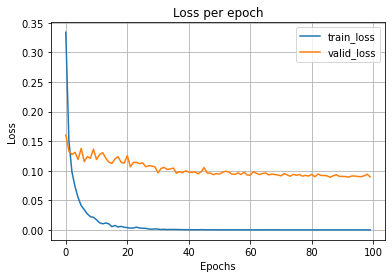

<Figure size 432x288 with 0 Axes>

In [24]:
#Plotting Loss
plt.plot(train_loss, label='train_loss')
plt.plot(test_loss, label='valid_loss')
plt.title('Loss per epoch')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid()
plt.show()
plt.savefig('loss.jpg')

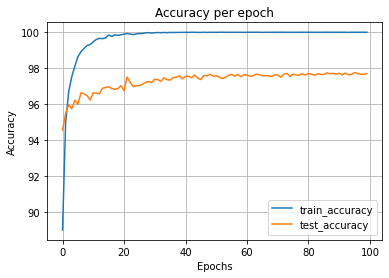

<Figure size 432x288 with 0 Axes>

In [25]:
#Plotting Loss
plt.plot(train_accuracy, label='train_accuracy')
plt.plot(test_accuracy, label='test_accuracy')
plt.title('Accuracy per epoch')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.grid()
plt.show()
plt.savefig('accuracy.jpg')